In [1]:

import numpy as np
import torch

from matplotlib import pyplot as plt



In [2]:

# instance the rng
rng = np.random.default_rng(seed=1919)

# create some ellipsoidal data
# a,b ellipse parameters, theta rotation in radians
# x,y shift
def ellipse_sample_exact(a,b,theta,x,y,npoints=15):
    
    rotation = np.array([
        [np.cos(-theta), -np.sin(-theta)], 
        [np.sin(-theta), np.cos(-theta)]
    ])
    
    phi_sample = rng.uniform(low=0,high=1,size=(npoints,1)) * 2.* np.pi
    u_sample = a * np.cos( phi_sample )
    y_sample = b * np.sin( phi_sample )

    coords = np.concatenate((u_sample,y_sample), axis=-1)
    coords = np.matmul(coords,rotation)
    
    coords += np.array([[x,y]])
    
    return coords
    


In [3]:
X = ellipse_sample_exact(a=4,b=1,theta=0.1,x=2,y=3, npoints=15)
print(X.shape)

def plot_scatter(X,xlim=[-10,10],ylim=[-10,10]):
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1])
    ax.grid(True, which='both')

    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()

# for i in range(5):
#     theta = (i / 5.)*np.pi
#     X = ellipse_sample_exact(a=4,b=1,theta=theta,x=2,y=3,npoints=100)
#     plot_scatter(X)

(15, 2)


In [4]:

# change euclidean points (xy) to ellipsoidal parameters (ep)
# [x**2, xy, y**2, x, y, 1 ]
def coords_euclidean_to_ep(X):
    new_coords = torch.stack([X[:,0]**2,X[:,0]*X[:,1],X[:,1]**2,X[:,0],X[:,1],torch.ones_like(X[:,0])],axis=1)
    return new_coords

# # change parameters from ep to a,b,theta,x,y
# # https://mathworld.wolfram.com/Ellipse.html
# #
# def params_ep_to_ab(P):
#     A,B,C,D,E,F = P[:,0],P[:,1],P[:,2],P[:,3],P[:,4],P[:,5]
    
#     #conventions for wolfram
# #     B /= 2
# #     D /= 2
# #     E /= 2
    
#     deter = B*B/4. - A*C
#     print(deter)
    
#     if deter >= 0:
#         print("WARNING: not an ellipse, determinant less than zero.")
    
#     a = torch.sqrt(
#         2*(A*E*E/4. + C*D*D/4. + F*B*B/4. - B*D*E/2. - A*C*F) /
#         (B*B/4.-A*C)*(torch.sqrt((A-C)*(A-C) + B*B) - (A+C))
#     )
#     b = torch.sqrt(
#         2*(A*E*E/4. + C*D*D/4. + F*B*B/4. - B*D*E/2. - A*C*F) /
#         (B*B/4.-A*C)*(-torch.sqrt((A-C)*(A-C) + B*B) - (A+C))
#     )
                   
# #     a =
# #     -torch.sqrt(
# #         2*(A*E*E + C*D*D - B*D*E + (B*B - 4*A*C)*F)*((A+C)+torch.sqrt((A-C)*(A-C)+B*B))
# #     ) / (B*B - 4*A*C)
# #     b = -torch.sqrt(2*(A*E*E + C*D*D - B*D*E + (B*B - 4*A*C)*F)*((A+C)-torch.sqrt((A-C)*(A-C)+B*B)))/(B*B - 4*A*C)

#     if a < b:
#         a,b = b,a
    
#     x = (C*D/2. - B*E/4.) / (B*B/4. - A*C)
#     y = (A*E/2. - B*D/4.) / (B*B/4. - A*C)

#     theta = 0.5 * torch.atan2(-B,C-A)
#     return torch.stack((a,b,theta,x,y),axis=-1)

# # change parameters from ep to a,b,theta,x,y
# # https://mathworld.wolfram.com/Ellipse.html
# #
# def params_ep_to_ab_wiki(P):
#     A,B,C,D,E,F = P[:,0],P[:,1],P[:,2],P[:,3],P[:,4],P[:,5]
    
#     deter = B*B - A*C
#     print(deter)
    
#     if deter >= 0:
#         print("WARNING: not an ellipse, determinant less than zero.")
                   
#     a = -torch.sqrt(
#         2*(A*E*E + C*D*D - B*D*E + (B*B - 4*A*C)*F)*((A+C)+torch.sqrt((A-C)*(A-C)+B*B))
#     ) / (B*B - 4*A*C)
#     b = -torch.sqrt(2*(A*E*E + C*D*D - B*D*E + (B*B - 4*A*C)*F)*((A+C)-torch.sqrt((A-C)*(A-C)+B*B)))/(B*B - 4*A*C)

#     if a < b:
#         a,b = b,a
    
#     x = (2*C*D - B*E) / (B*B - 4*A*C)
#     y = (2*A*E - B*D) / (B*B - 4*A*C)

#     theta = 0.5 * torch.atan2(-B,C-A)
#     return torch.stack((a,b,theta,x,y),axis=-1)


# change parameters from ep to a,b,theta,x,y
# https://www.geometrictools.com/Documentation/InformationAboutEllipses.pdf
#
#def params_ep_to_ab_SO(P):
def params_ep_to_ab(P):
    A,B,C,D,E,F = P[:,0],P[:,1],P[:,2],P[:,3],P[:,4],P[:,5]
    
    B_half = B/2.
    
    k1 = (C*D - B_half*E) / (2*(B_half*B_half - A*C))
    k2 = (A*E - B_half*D) / (2*(B_half*B_half - A*C))
    mu = 1./(A*k1*k1 + 2*B_half*k1*k2 + C*k2*k2 - F)
    
    m11 = mu*A
    m12 = mu*B_half
    m22 = mu*C
    
    lambda1 = (0.5)*(m11 + m22+torch.sqrt((m11-m22)**2 + 4*(m12**2)))
    lambda2 = (0.5)*(m11 + m22-torch.sqrt((m11-m22)**2 + 4*(m12**2)))

    
    a = 1./torch.sqrt(lambda1)
    b = 1./torch.sqrt(lambda2)
    if a < b:
        a,b = b,a
    
    theta = 0.5 * torch.atan2(-2*B_half,C-A)
    
    return torch.stack((a,b,theta,k1,k2),axis=-1)


# change parameters from a,b,theta,x,y to ep
# https://en.wikipedia.org/wiki/Ellipse#General_ellipse
#
def params_ab_to_ep(P):
    a,b,theta,x,y = P[:,0],P[:,1],P[:,2],P[:,3],P[:,4]
    
    sintheta = torch.sin(theta)
    costheta = torch.cos(theta)
    
    A = a*a*sintheta*sintheta + b*b*costheta*costheta
    B = 2*(b*b - a*a)*sintheta*costheta
    C = a*a*costheta*costheta + b*b*sintheta*sintheta
    
    D = -2*A*x - B*y
    E = -B*x - 2*C*y
    F = A*x*x + B*x*y + C*y*y - a*a*b*b
    
    return torch.stack((A,B,C,D,E,F),axis=-1)
    

In [5]:

# a=4,b=1,theta=0.1,x=2,y=3
P = torch.tensor([[4,1,0.1,2,3]])
P_ep = params_ab_to_ep(P)
P_ab = params_ep_to_ab(P_ep)
#P_ab = params_ep_to_ab_SO(P_ep)

print(P)
print(P_ep)
print(P_ab)


tensor([[4.0000, 1.0000, 0.1000, 2.0000, 3.0000]])
tensor([[  1.1495,  -2.9800,  15.8505,   4.3421, -89.1429, 113.3723]])
tensor([[4.0000, 1.0000, 0.1000, 2.0000, 3.0000]])


In [6]:

# SVD Fitzgibbon 1996
def fitzgibbon(M_mat,C_mat):
    U, s, V = torch.svd(torch.matmul(torch.linalg.inv(M_mat).to(torch.float32), C_mat.to(torch.float32)))
    a = U[:, 0:1]
    return torch.transpose(a,-2,-1)

# halir flusser 1998
def halir_flusser(M_mat,C1_mat):
    S1 = M_mat[0:3,0:3]
    S2 = M_mat[0:3,3:]
    S2_t = M_mat[3:,0:3]
    S3 = M_mat[3:,3:]
#     print(M_mat)  
#     print(S3)
    
    T = -torch.linalg.inv(S3) @ torch.transpose(S2,-2,-1)
    M1 = torch.linalg.inv(C1_mat.to(torch.float32)) @ (S1 + S2@T)
    # lstsq_output = torch.linalg.lstsq(M1.to(torch.float32), C1_mat.to(torch.float32))
    # a1 = lstsq_output.solution
    
    U,S,V = torch.svd(M1)
    
    cond = 4* U[0,:] * U[2,:] - U[1,:]**2
#     print(cond)
#     print(U,S,V)
    a1 = U[:,2:3]
    
    a2 = T @ a1
    
    return torch.transpose(torch.concat((a1,a2),axis=-2),-2,-1)


def coords_to_scatter_mat(X):
    X_ep = coords_euclidean_to_ep(X)

    X_ep_T = torch.transpose(X_ep,-2,-1)

    # print(X_ep)
    # print(X_ep_T)

    M_matrix = torch.zeros((6,6))
    for i in range(X_ep.shape[0]):
       M_matrix += torch.matmul( X_ep_T[:,i:i+1], X_ep[i:i+1,:] ) 
    #M_matrix = torch.matmul(X_ep_T,X_ep)
    return M_matrix

def constraint_mats():
    constraint_mat_1 = torch.tensor([[1,0],[0,0]])
    constraint_mat_2 = torch.tensor([[0,0,2],[0,-1,0],[2,0,0]])
    C = torch.kron(constraint_mat_1,constraint_mat_2)
    return constraint_mat_1, constraint_mat_2, C


In [7]:
X = ellipse_sample_exact(a=4,b=1,theta=0.1,x=0,y=0, npoints=15)

X = torch.tensor(X)
X_rand = X + torch.randn_like(X)*0.01

M_matrix = coords_to_scatter_mat(X_rand)

constraint_mat_1, constraint_mat_2, C = constraint_mats()

fg_output = fitzgibbon(M_matrix.to(torch.float32),C.to(torch.float32))
print("fitzgibbon",fg_output)
fg_output_ab = params_ep_to_ab(fg_output)
print("fitzgibbon", fg_output_ab)

hf_output = halir_flusser(M_matrix.to(torch.float32),constraint_mat_2.to(torch.float32))
print("halir_flusser", hf_output)
hf_output_ab = params_ep_to_ab(hf_output)
print("halir_flusser", hf_output_ab)


fitzgibbon tensor([[-5.1381e-02,  1.3371e-01, -6.9532e-01, -1.4235e-04,  7.0662e-04,
          7.0428e-01]])
fitzgibbon tensor([[ 3.9777e+00,  1.0015e+00, -1.4684e+00, -8.2759e-04,  4.2856e-04]])
halir_flusser tensor([[ 0.9927,  0.0955,  0.0734,  0.4292,  0.8183, -7.8510]])
halir_flusser tensor([[11.9577,  3.1914, -1.5191,  0.0537, -5.6126]])


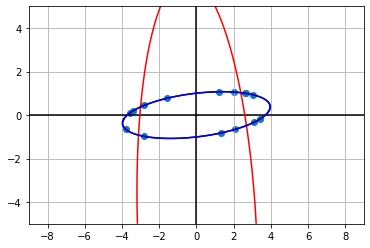

In [24]:
x_grid = np.linspace(-9, 9, 400)
y_grid = np.linspace(-5, 5, 400)
x_mgrid, y_mgrid = np.meshgrid(x_grid, y_grid)

fig, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1])
ax.grid(True, which='both')

ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')


hf_output_np = hf_output_ab.numpy()
a,b,theta,x,y = hf_output_np[0,0],hf_output_np[0,1],hf_output_np[0,2],hf_output_np[0,3],hf_output_np[0,4]
hf_output_np = hf_output.numpy()
A,B,C,D,E,F = hf_output_np[0,0],hf_output_np[0,1],hf_output_np[0,2],hf_output_np[0,3],hf_output_np[0,4],hf_output_np[0,5]

#plt.contour(x_mgrid,y_mgrid, ((x_mgrid-x)**2/a**2) + ((y_mgrid-y)**2/b**2), [1], colors="k" )
plt.contour(x_mgrid,y_mgrid, A*x_mgrid*x_mgrid + B*x_mgrid*y_mgrid + C*y_mgrid*y_mgrid + D*x_mgrid + E*y_mgrid + F, [0], colors="r" )


fg_output_ab_np = fg_output_ab.numpy()
a,b,theta,x,y = fg_output_ab_np[0,0],fg_output_ab_np[0,1],fg_output_ab_np[0,2],fg_output_ab_np[0,3],fg_output_ab_np[0,4]
fg_output_np = fg_output.numpy()
A,B,C,D,E,F = fg_output_np[0,0],fg_output_np[0,1],fg_output_np[0,2],fg_output_np[0,3],fg_output_np[0,4],fg_output_np[0,5]

#plt.contour(x_mgrid,y_mgrid, ((x_mgrid-x)**2/a**2) + ((y_mgrid-y)**2/b**2), [1], colors="g" )
plt.contour(x_mgrid,y_mgrid, A*x_mgrid*x_mgrid + B*x_mgrid*y_mgrid + C*y_mgrid*y_mgrid + D*x_mgrid + E*y_mgrid + F,
            [0], colors="k", hatches=["\\"])



a=4
b=1
theta=0.1
x=0
y=0
coords_gt_ab = torch.tensor([[a,b,theta,x,y]])
coords_gt_ep = params_ab_to_ep(coords_gt_ab)
A,B,C,D,E,F = coords_gt_ep[0,0],coords_gt_ep[0,1],coords_gt_ep[0,2],coords_gt_ep[0,3],coords_gt_ep[0,4],coords_gt_ep[0,5]

#plt.contour(x_mgrid,y_mgrid, ((x_mgrid-x)**2/a**2) + ((y_mgrid-y)**2/b**2), [1], colors="b" )
plt.contour(x_mgrid,y_mgrid, A*x_mgrid*x_mgrid + B*x_mgrid*y_mgrid + C*y_mgrid*y_mgrid + D*x_mgrid + E*y_mgrid + F,
            [0], colors="b", hatches=["."])

plt.show()